<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [18]:
# Check for GPU
!nvidia-smi

Thu Aug  8 09:44:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.30                 Driver Version: 546.30       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8              17W / 115W |   2937MiB /  8192MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

2.3.0


device(type='cuda')

## 1. What are 3 areas in industry where computer vision is currently being used?

* Classification
* Object detection
* Segmentation

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

Overfitting is an undesirable machine learning behavior that occurs when the machine learning model gives accurate predictions for training data but not for new data.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

* Regularization
* Cross validation
* Early stopping

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

![CNN Explainer](img/cnn_explainer.png)

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [20]:
import torchvision
from torchvision.transforms import v2

data_root = "./data"
preproc = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])
train_ds = torchvision.datasets.MNIST(root=data_root, train=True, transform=preproc, download=True)
test_ds = torchvision.datasets.MNIST(root=data_root, train=False, transform=preproc, download=True)

In [21]:
from collections import Counter

label_counter = Counter((x.item() for x in train_ds.targets))
label_counter

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

## 6. Visualize at least 5 different samples of the MNIST training dataset.

In [22]:
sample_tensor, _ = train_ds[0]
sample_tensor.shape

torch.Size([1, 28, 28])

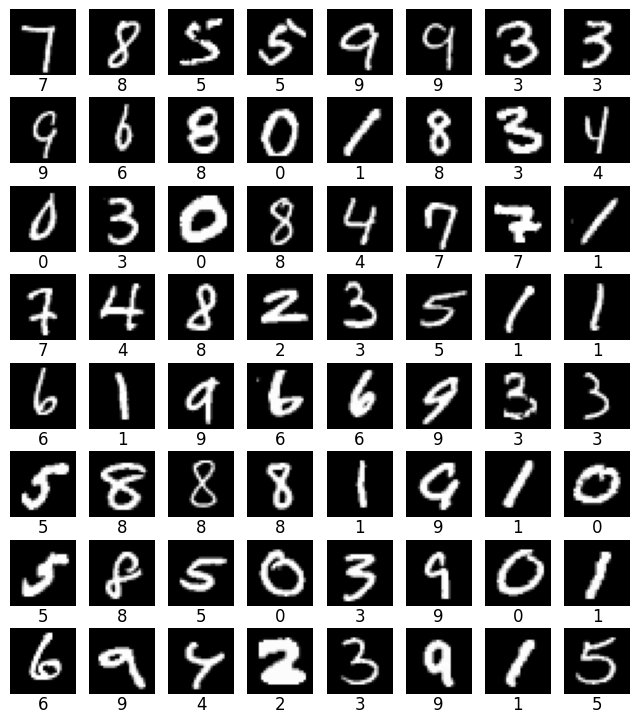

In [23]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 9))
cols, rows = 8, 8
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_ds), size=(1,)).item()
    img, label = train_ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label, y=-0.35)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [24]:
from torch.utils.data import DataLoader

batch_size = 32
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [25]:
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, img_channels: int, img_height: int, img_width: int, num_classes: int, hidden_units: int = 10):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=img_channels, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*(img_height//2//2)*(img_width//2//2), out_features=num_classes),
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [57]:
img_channels, img_height, img_width = sample_tensor.shape
num_classes = len(label_counter)
model_2 = TinyVGG(img_channels, img_height, img_width, num_classes, hidden_units=10)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [54]:
def train_step(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        accuracy_fn,
        device: torch.device = device,
):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for X, y in data_loader:
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [55]:
def test_step(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        accuracy_fn,
        device: torch.device = device,
):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [58]:
# Setup loss and optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

In [50]:
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [30]:
from timeit import default_timer as timer 

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [31]:
epochs = 5
cpu_device = torch.device("cpu")
gpu_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [59]:
cpu_start_time = timer()
for epoch in range(1, epochs+1):
    print(f"Epoch: {epoch}\n---------")
    train_step(model_2, train_dataloader, optimizer, loss_fn, acc_fn, cpu_device)
    test_step(model_2, test_dataloader, loss_fn, acc_fn, cpu_device)
cpu_end_time = timer()
print_train_time(cpu_start_time, cpu_end_time, cpu_device)

Epoch: 1
---------
Train loss: 0.28318 | Train accuracy: 90.75%
Test loss: 0.08663 | Test accuracy: 97.09%

Epoch: 2
---------
Train loss: 0.07641 | Train accuracy: 97.64%
Test loss: 0.05451 | Test accuracy: 98.22%

Epoch: 3
---------
Train loss: 0.06040 | Train accuracy: 98.09%
Test loss: 0.04383 | Test accuracy: 98.59%

Epoch: 4
---------
Train loss: 0.05075 | Train accuracy: 98.41%
Test loss: 0.03889 | Test accuracy: 98.82%

Epoch: 5
---------
Train loss: 0.04537 | Train accuracy: 98.60%
Test loss: 0.04198 | Test accuracy: 98.56%

Train time on cpu: 142.576 seconds


142.57556480029598

In [60]:
gpu_start_time = timer()
for epoch in range(1, epochs+1):
    print(f"Epoch: {epoch}\n---------")
    train_step(model_2, train_dataloader, optimizer, loss_fn, acc_fn, gpu_device)
    test_step(model_2, test_dataloader, loss_fn, acc_fn, gpu_device)
gpu_end_time = timer()
print_train_time(gpu_start_time, gpu_end_time, gpu_device)

Epoch: 1
---------
Train loss: 0.03893 | Train accuracy: 98.75%
Test loss: 0.04578 | Test accuracy: 98.53%

Epoch: 2
---------
Train loss: 0.03659 | Train accuracy: 98.83%
Test loss: 0.03948 | Test accuracy: 98.70%

Epoch: 3
---------
Train loss: 0.03314 | Train accuracy: 98.94%
Test loss: 0.03927 | Test accuracy: 98.74%

Epoch: 4
---------
Train loss: 0.03130 | Train accuracy: 98.97%
Test loss: 0.03946 | Test accuracy: 98.77%

Epoch: 5
---------
Train loss: 0.02972 | Train accuracy: 99.05%
Test loss: 0.04201 | Test accuracy: 98.82%

Train time on cuda: 90.957 seconds


90.95657749986276

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

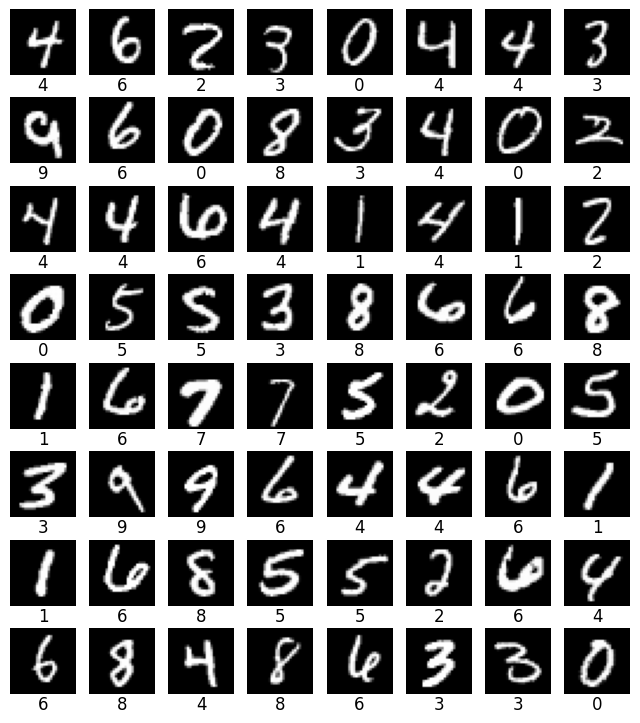

In [84]:
model_2.to(device)
model_2.eval()
figure = plt.figure(figsize=(8, 9))
cols, rows = 8, 8
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_ds), size=(1,)).item()
    img, y = test_ds[sample_idx]
    X = torch.unsqueeze(img, 0) # add batch dimension
    X = X.to(device)
    with torch.inference_mode():
        test_pred = model_2(X).argmax(dim=1).item()
    figure.add_subplot(rows, cols, i)
    label = test_pred if y == test_pred else f"{test_pred} vs {y}"
    plt.title(label, y=-0.35)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [86]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
y_targets = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_2(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        y_targets.append(y.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_target_tensor = torch.cat(y_targets)

Making predictions: 100%|██████████| 313/313 [00:02<00:00, 139.63it/s]


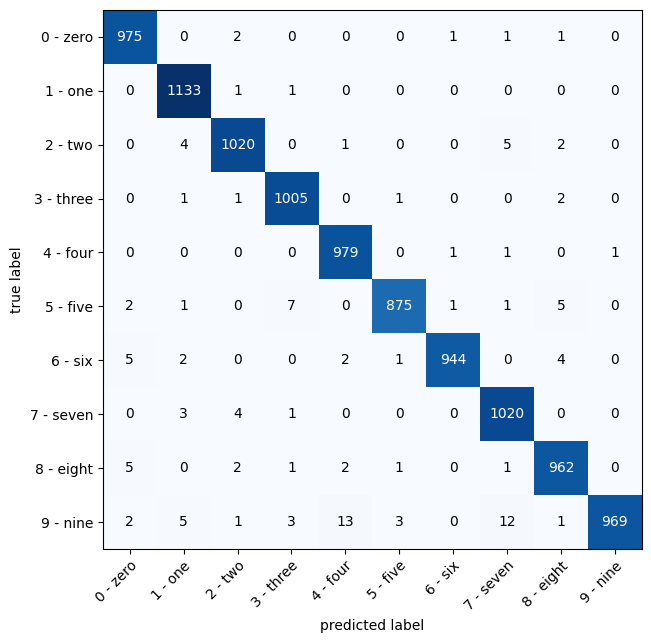

In [89]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

class_names = train_ds.classes

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=y_target_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [90]:
rand_tensor = torch.rand(1, 3, 64, 64)

In [91]:
conv_1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)
conv_tensor_1 = conv_1(rand_tensor)
conv_tensor_1.shape

torch.Size([1, 3, 62, 62])

In [92]:
conv_2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5)
conv_tensor_2 = conv_2(rand_tensor)
conv_tensor_2.shape

torch.Size([1, 3, 60, 60])

Size of resulting tensor reduced when increasing kernel size

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [101]:
preproc = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])
fashion_train_ds = torchvision.datasets.FashionMNIST(root="data", train=True, transform=preproc, download=True)
fashion_test_ds = torchvision.datasets.FashionMNIST(root="data", train=False, transform=preproc, download=True)

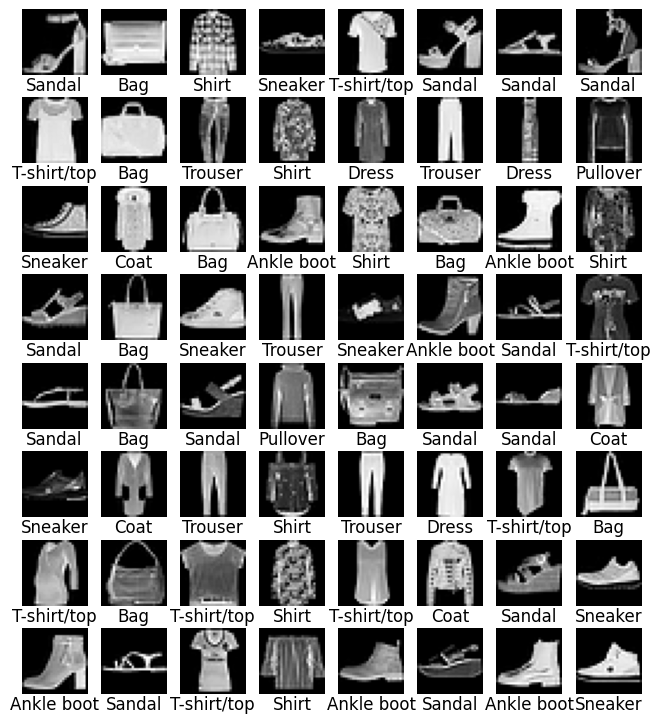

In [112]:
from torch.utils.data import RandomSampler
from torchvision.transforms.functional import to_pil_image

rows, cols = 8, 8
data_sampler = RandomSampler(fashion_train_ds, num_samples=rows*cols)
figure = plt.figure(figsize=(8, 9))
for i, sample_idx in enumerate(data_sampler):
    figure.add_subplot(rows, cols, i+1)
    X, y = fashion_train_ds[sample_idx]
    img = to_pil_image(X)
    label = fashion_train_ds.classes[y]
    plt.title(label, y=-0.35)
    plt.axis("off")
    plt.imshow(to_pil_image(X), cmap="gray")
plt.show()


In [113]:
train_shape_counter = Counter((X.shape for X, _ in fashion_train_ds))
train_shape_counter

Counter({torch.Size([1, 28, 28]): 60000})

In [114]:
test_shape_counter = Counter((X.shape for X, _ in fashion_test_ds))
test_shape_counter

Counter({torch.Size([1, 28, 28]): 10000})

In [122]:
img_shape, _ = train_shape_counter.most_common(1)[0]
img_channels, img_height, img_width = img_shape
num_classes = len(fashion_train_ds.classes)

In [123]:
batch_size = 32
train_dataloader = DataLoader(fashion_train_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(fashion_test_ds, batch_size=batch_size)

In [124]:
fashion_model = TinyVGG(img_channels, img_height, img_width, num_classes, hidden_units=10)

In [125]:
# Setup loss and optimizer
optimizer = torch.optim.SGD(params=fashion_model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

In [126]:
num_epochs = 10
start_time = timer()
for epoch in range(1, num_epochs+1):
    print(f"Epoch: {epoch}\n---------")
    train_step(fashion_model, train_dataloader, optimizer, loss_fn, acc_fn, device)
    test_step(fashion_model, test_dataloader, loss_fn, acc_fn, device)
end_time = timer()
print_train_time(start_time, end_time, device)

Epoch: 1
---------
Train loss: 0.69262 | Train accuracy: 74.72%
Test loss: 0.42106 | Test accuracy: 84.84%

Epoch: 2
---------
Train loss: 0.36036 | Train accuracy: 87.06%
Test loss: 0.34554 | Test accuracy: 87.41%

Epoch: 3
---------
Train loss: 0.31680 | Train accuracy: 88.70%
Test loss: 0.32118 | Test accuracy: 88.54%

Epoch: 4
---------
Train loss: 0.29336 | Train accuracy: 89.37%
Test loss: 0.31679 | Test accuracy: 88.85%

Epoch: 5
---------
Train loss: 0.27893 | Train accuracy: 89.87%
Test loss: 0.29890 | Test accuracy: 89.14%

Epoch: 6
---------
Train loss: 0.26972 | Train accuracy: 90.17%
Test loss: 0.29951 | Test accuracy: 89.03%

Epoch: 7
---------
Train loss: 0.26239 | Train accuracy: 90.48%
Test loss: 0.30241 | Test accuracy: 89.32%

Epoch: 8
---------
Train loss: 0.25655 | Train accuracy: 90.74%
Test loss: 0.28895 | Test accuracy: 89.37%

Epoch: 9
---------
Train loss: 0.25182 | Train accuracy: 90.77%
Test loss: 0.28884 | Test accuracy: 89.55%

Epoch: 10
---------
Train lo

179.16272300016135

In [127]:
# 1. Make predictions with trained model
y_preds = []
y_targets = []
fashion_model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = fashion_model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        y_targets.append(y.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_target_tensor = torch.cat(y_targets)

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 172.43it/s]


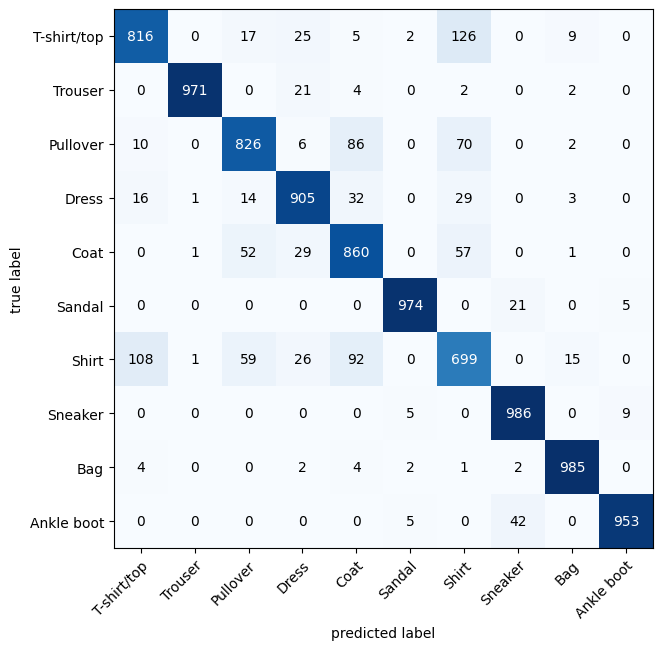

In [128]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=num_classes, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=y_target_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=fashion_train_ds.classes, # turn the row and column labels into class names
    figsize=(10, 7)
)

In [136]:
mistake_indices = (y_pred_tensor != y_target_tensor).nonzero().flatten()
mistake_indices.shape

torch.Size([1025])

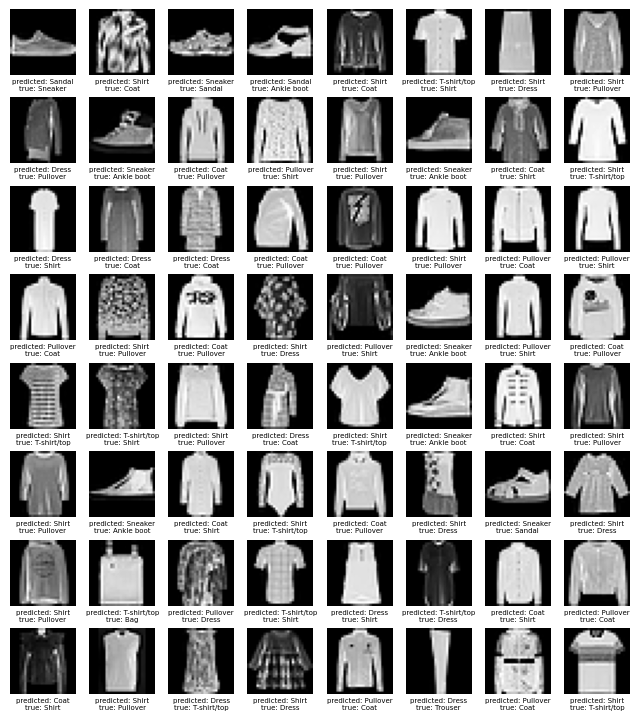

In [143]:
mistake_indices = (y_pred_tensor != y_target_tensor).nonzero().flatten()
rows, cols = 8, 8
figure = plt.figure(figsize=(8, 9))
for i, mistake_idx in enumerate(mistake_indices):
    if i >= rows*cols:
        break
    figure.add_subplot(rows, cols, i+1)
    X, _ = fashion_test_ds[mistake_idx]
    img = to_pil_image(X)
    y_pred = y_pred_tensor[mistake_idx]
    y_true = y_target_tensor[mistake_idx]
    label_pred = fashion_train_ds.classes[y_pred]
    label_true = fashion_train_ds.classes[y_true]
    label = f"predicted: {label_pred}\ntrue: {label_true}"
    plt.title(label, y=-0.35, fontsize = 5)
    plt.axis("off")
    plt.imshow(to_pil_image(X), cmap="gray")
plt.show()

The misclassification has more to do with the data itself. Some of the classes are too similar